# Estimer le prix d'un bien immobilier avec une méthode d'apprentissage machine
### **Pierre-Edouard GUERIN**
#### 01/03/2020

# Introduction

## Contexte
*Demandez à un acheteur de décrire la maison de ses rêves, et il ne commencera probablement pas par la hauteur du plafond du sous-sol ou la proximité d'un chemin de fer est-ouest. Mais ce jeu de données montre que les négociations de prix sont beaucoup plus influencées que le nombre de chambres à coucher ou une clôture en piquets blancs.*

Avec 79 variables explicatives décrivant (presque) tous les aspects de quelques 3000 habitations residentielles à Boston, il faudra définir quelles variables influencent le prix de vente d'un bien immobilier.

## Mission
L'objectif est de prédire le prix de vente d'un jeu de données de biens immobiliers. Pour chaque identifiant de bien immobilier, un prix de vente doit être assigné.

## Script
Ce script utilise des techniques de regression et de transformation des données. D'abord il s'agit de procéder à la curation des données, puis de transformer les descripteurs pour les besoins du modèle. Enfin, la modélisation et la prédiction du prix de vente des biens immobiliers.


# Prérequis

In [1]:
#==============================================================================
#MODULES
#==============================================================================
import argparse
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
import scipy.stats as stats
import xgboost as xgb
import lightgbm as lgb
import warnings


warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')

# Charger et explorer le jeu de données

In [2]:
# download data https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

trainDatFile="data/house_prices_advanced_regression_techniques/train.csv"
testDatFile="data/house_prices_advanced_regression_techniques/test.csv"

train = pd.read_csv(trainDatFile)
test = pd.read_csv(testDatFile)

In [3]:
train.shape

(1460, 81)

In [4]:
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


Le jeu de données présente 81 descripteurs, ce qui est beaucoup alors nous n'allons pas tous les explorer mais nous concentrer sur les plus explicatifs.

De plus, après l'encodage des variables qualitatives nominales, le nombre de colonnes de la nouvelle table risque d'être inutilement trop grand pour nos capacités de calcul.

In [5]:
# variables quantitatives
train.select_dtypes(include=['int64','float64']).columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

Le jeu de donnée contient 38 variables quantitatives et 43 variables qualitatives.

In [6]:
# drop useless "Id" feature
train = train.drop(labels = ["Id"],axis = 1)
test = test.drop(labels = ["Id"],axis = 1)

La variable "Id" (identifiant) n'est pas nécessaire, elle est donc retirée du jeu.

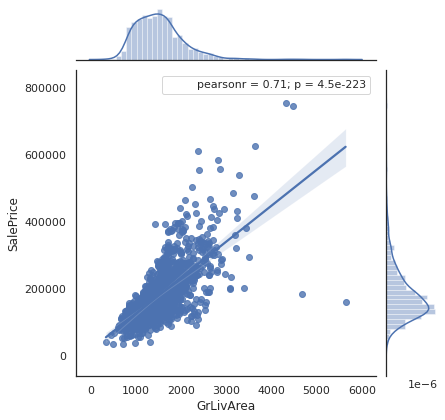

In [7]:
g = sns.jointplot(x = train['GrLivArea'], y = train['SalePrice'],kind="reg")
g.annotate(stats.pearsonr)

Il y a une forte corrélation entre le prix du bien "SalePrice" et la surface habitable "GrLivArea" (coefficient de Pearson: 0.71)

# Expliquer la variable du prix de vente



In [8]:
train['SalePrice'].describe()


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

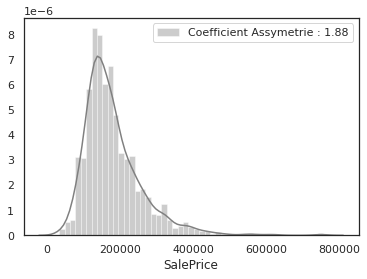

In [9]:
g = sns.distplot(train['SalePrice'],color="gray")
g = g.legend(["Coefficient Assymetrie : {:.2f}".format(train['SalePrice'].skew())],loc='best')

Le coefficient d'assymetrie de la variable `SalePrice` est positif. Cependant les modèles linéaires nécessitent une distribution normale. Il faudra donc transformer cette distribution assymétrique en distribution normale.


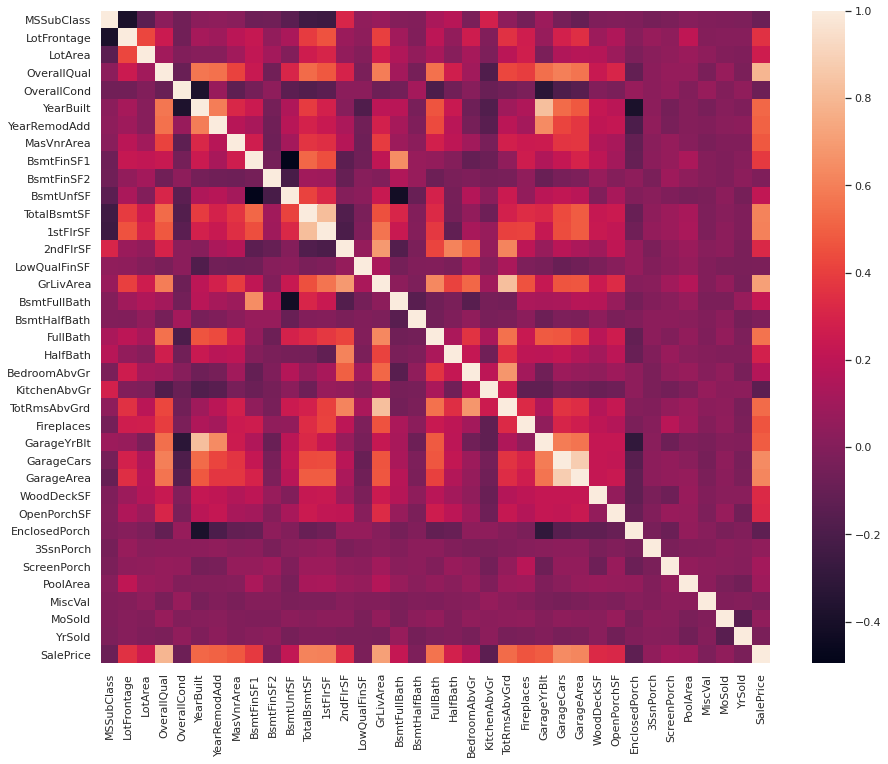

In [10]:
corrmat = train.corr()
plt.subplots(figsize=(15,12))
g = sns.heatmap(train.corr())

Il y a une forte correlation entre `SalePrice` et `OverallQual`, `GrLivArea`, `1stFlrSF`, `GarageCars`, `GarageArea`.
Je selectionne les variables qui ont un coefficient de corrélation supérieur à 0,5 avec `SalePrice`

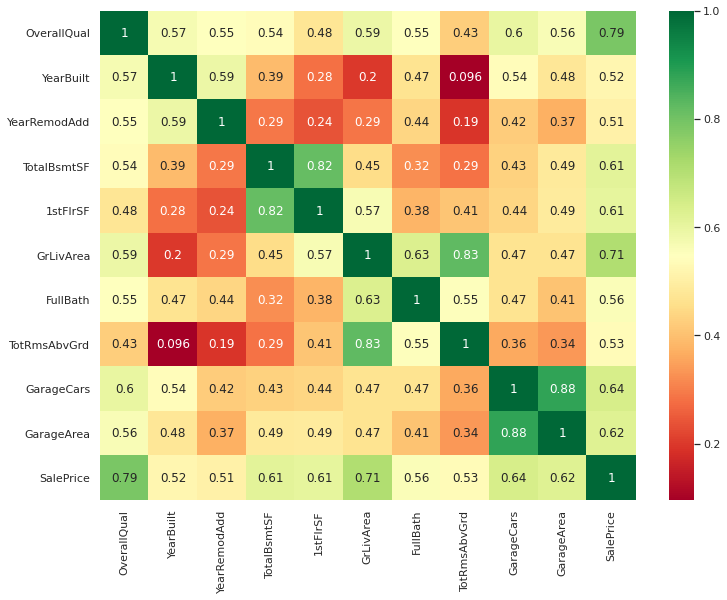

In [11]:
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.subplots(figsize=(12,9))
g = sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Il s'agit de la heatmap des variables les plus corrélées à `SalePrice`. Avec une correlation de 0.79 et 0.71 respectivement, `OverallQual` et `GrLivArea` respectivement, sont les variables les plus fortement corrélées.

Maintenant, je vais explorer les relations entre les variables les plus corrélées à `SalePrice`.

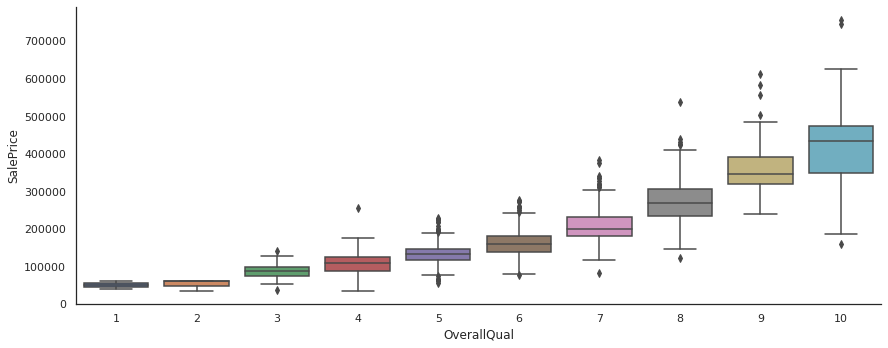

In [12]:
g = sns.factorplot(x="OverallQual",y="SalePrice",data=train,kind='box',aspect=2.5)

Dans le cas de la variable la plus corrélée à `SalePrice` *i.e.* `OverallQual`, la relation linéaire est évidente. Le prix de vente tend à augmenter proportionnellement à la qualité d'ensemble de la maison.

En ce qui concerne les autres variables fortement corrélées :

In [13]:
def multiplot(data,features,plottype,nrows,ncols,figsize,y=None,colorize=False):
    """ This function draw a multi plot for 3 types of plots ["regplot","distplot","coutplot"]"""
    n = 0
    plt.figure(1)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)    
    if colorize:
        colors = sns.color_palette(n_colors=(nrows*ncols))
    else :
        colors = [None]*(nrows*ncols)        
    for row in range(nrows):
        for col in range(ncols):            
            if plottype == 'regplot':
                if y == None:
                    raise ValueError('y value is needed with regplot type')                
                sns.regplot(data = data, x = features[n], y = y ,ax=axes[row,col], color = colors[n])
                correlation = np.corrcoef(data[features[n]],data[y])[0,1]
                axes[row,col].set_title("Correlation {:.2f}".format(correlation))            
            elif plottype == 'distplot':
                sns.distplot(a = data[features[n]],ax = axes[row,col],color=colors[n])
                skewness = data[features[n]].skew()
                axes[row,col].legend(["Skew : {:.2f}".format(skewness)])            
            elif plottype in ['countplot']:
                g = sns.countplot(x = data[features[n]], y = y, ax = axes[row,col],color = colors[n])
                g = plt.setp(g.get_xticklabels(), rotation=45)                
            n += 1
    plt.tight_layout()
    plt.show()
    plt.gcf().clear()

La fonction *multiplot* permet d'afficher 3 figures à partir d'une même donnée:
* La droite de la regression linéaire qui va avec les données
* L'histogramme de la distribution univariée des obersvations
* Barplot du nombre d'observations dans chaque catégorie pour les variables qualitatives

Ici j'affiche la droite de la regression linéaire entre ces variables et la variable `SalePrice`.

<Figure size 432x288 with 0 Axes>

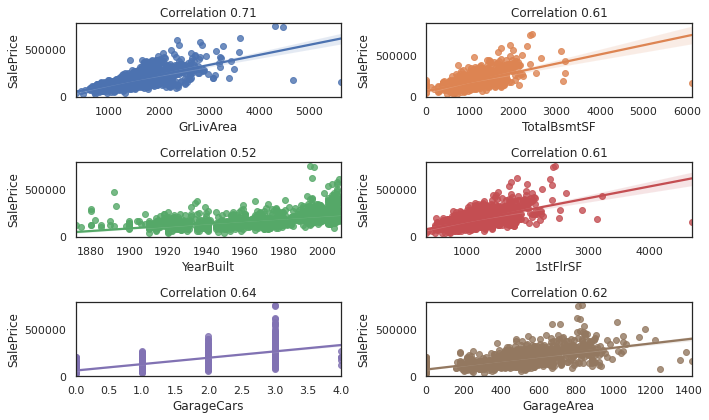

<Figure size 432x288 with 0 Axes>

In [14]:
feats = ["GrLivArea","TotalBsmtSF", "YearBuilt", "1stFlrSF", "GarageCars", "GarageArea"]
multiplot(data = train, features = feats, plottype = "regplot",nrows = 3, ncols = 2, figsize = (10,6), y = "SalePrice", colorize = True)

Toutes ces variables semblent bien avoir une relation linéaire avec `SalePrice`

# 4 Curation des données

In [15]:
## Join train and test datasets in order to avoid obtain the same number of feature during categorical conversion
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [16]:
dataset = dataset.fillna(np.nan)

Les variables avec au moins une donnée manquante.

In [17]:
missing_features = dataset.columns[dataset.isnull().any()]
missing_features

Index(['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SalePrice'],
      dtype='object')

Nombre de données manquantes par variable.

In [18]:
dataset[missing_features].isnull().sum().sort_values(ascending=False)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageCond       159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Utilities          2
BsmtFinSF2         1
BsmtUnfSF          1
BsmtFinSF1         1
TotalBsmtSF        1
SaleType           1
KitchenQual        1
Exterior2nd        1
Exterior1st        1
GarageCars         1
GarageArea         1
Electrical         1
dtype: int64

35 variables présentent des données manquantes. En se référant à la description des données [data/house_prices_advanced_regression_techniques/data_description.txt](data/house_prices_advanced_regression_techniques/data_description.txt). Pour la plupart de ces variables, la valeur *NaN* signifie l'absence. Donc par exemple pour le cas d'une allée `Alley` *NaN* signifie qu'il n'y a pas d'allée pour cette maison, ce qui est une information. Je renomme donc les valeurs *NaN* par la valeur "*No*" ou *0*.

In [19]:
## replace NaN values by "No" for categorical variables
dataset["Alley"] = dataset["Alley"].fillna("No")
dataset["MiscFeature"] = dataset["MiscFeature"].fillna("No")
dataset["Fence"] = dataset["Fence"].fillna("No")
dataset["PoolQC"] = dataset["PoolQC"].fillna("No")
dataset["FireplaceQu"] = dataset["FireplaceQu"].fillna("No")
dataset["BsmtCond"] = dataset["BsmtCond"].fillna("No")
dataset["BsmtQual"] = dataset["BsmtQual"].fillna("No")
dataset["BsmtFinType2"] = dataset["BsmtFinType2"].fillna("No")
dataset["BsmtFinType1"] = dataset["BsmtFinType1"].fillna("No")
dataset.loc[dataset["BsmtCond"] == "No","BsmtUnfSF"] = 0
dataset.loc[dataset["BsmtFinType1"] == "No","BsmtFinSF1"] = 0
dataset.loc[dataset["BsmtFinType2"] == "No","BsmtFinSF2"] = 0
dataset.loc[dataset["BsmtQual"] == "No","TotalBsmtSF"] = 0
dataset.loc[dataset["BsmtCond"] == "No","BsmtHalfBath"] = 0
dataset.loc[dataset["BsmtCond"] == "No","BsmtFullBath"] = 0
dataset["BsmtExposure"] = dataset["BsmtExposure"].fillna("No")
dataset["Alley"] = dataset["Alley"].fillna("No")
dataset["MiscFeature"] = dataset["MiscFeature"].fillna("No")
dataset["Fence"] = dataset["Fence"].fillna("No")
dataset["PoolQC"] = dataset["PoolQC"].fillna("No")
dataset["FireplaceQu"] = dataset["FireplaceQu"].fillna("No")
dataset["BsmtCond"] = dataset["BsmtCond"].fillna("No")
dataset["BsmtQual"] = dataset["BsmtQual"].fillna("No")
dataset["BsmtFinType2"] = dataset["BsmtFinType2"].fillna("No")
dataset["BsmtFinType1"] = dataset["BsmtFinType1"].fillna("No")
dataset.loc[dataset["BsmtCond"] == "No","BsmtUnfSF"] = 0
dataset.loc[dataset["BsmtFinType1"] == "No","BsmtFinSF1"] = 0
dataset.loc[dataset["BsmtFinType2"] == "No","BsmtFinSF2"] = 0
dataset.loc[dataset["BsmtQual"] == "No","TotalBsmtSF"] = 0
dataset.loc[dataset["BsmtCond"] == "No","BsmtHalfBath"] = 0
dataset.loc[dataset["BsmtCond"] == "No","BsmtFullBath"] = 0
dataset["BsmtExposure"] = dataset["BsmtExposure"].fillna("No")
dataset["Utilities"] = dataset["Utilities"].fillna("AllPub")
dataset["GarageType"] = dataset["GarageType"].fillna("No")
dataset["GarageFinish"] = dataset["GarageFinish"].fillna("No")
dataset["GarageQual"] = dataset["GarageQual"].fillna("No")
dataset["GarageCond"] = dataset["GarageCond"].fillna("No")
dataset.loc[dataset["GarageType"] == "No","GarageYrBlt"] = dataset["YearBuilt"][dataset["GarageType"]=="No"]
dataset.loc[dataset["GarageType"] == "No","GarageCars"] = 0
dataset.loc[dataset["GarageType"] == "No","GarageArea"] = 0
dataset["GarageArea"] = dataset["GarageArea"].fillna(dataset["GarageArea"].median())
dataset["GarageCars"] = dataset["GarageCars"].fillna(dataset["GarageCars"].median())
dataset["GarageYrBlt"] = dataset["GarageYrBlt"].fillna(dataset["GarageYrBlt"].median())
dataset["MasVnrType"] = dataset["MasVnrType"].fillna("None")
dataset.loc[dataset["MasVnrType"] == "None","MasVnrArea"] = 0

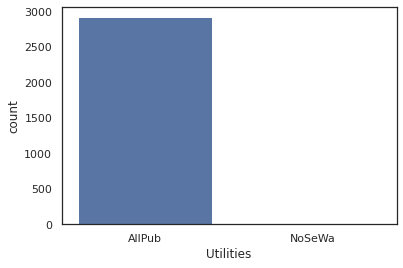

In [20]:
g = sns.countplot(dataset["Utilities"])
dataset["Utilities"] = dataset["Utilities"].fillna("AllPub")

Concernant, la variable `Utilities`, je remplace les données manquantes par la valeur catégorielle la plus commune.


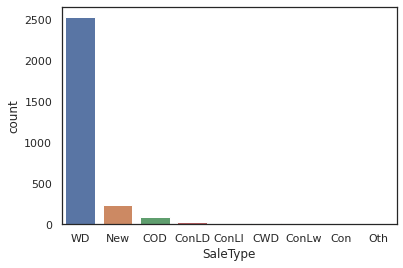

In [21]:
g = sns.countplot(dataset["SaleType"])
dataset["SaleType"] = dataset["SaleType"].fillna("WD")

Concernant la variable `SaleType`, je remplace les données manquantes par la valeur catégorielle la plus commune.

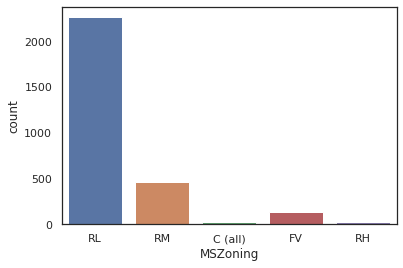

In [22]:
g = sns.countplot(dataset["MSZoning"])
dataset["MSZoning"] = dataset["MSZoning"].fillna("RL")

Concernant la variable `MSZoning`, je remplace les données manquantes par la valeur catégorielle la plus commune.

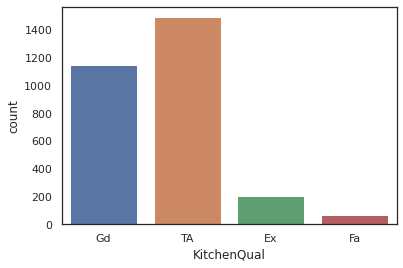

In [23]:
g = sns.countplot(dataset["KitchenQual"])
dataset["KitchenQual"] = dataset["KitchenQual"].fillna("TA")

Concernant la variable `KitchenQual`, je remplace les données manquantes par la valeur catégorielle la plus commune.

<Figure size 432x288 with 0 Axes>

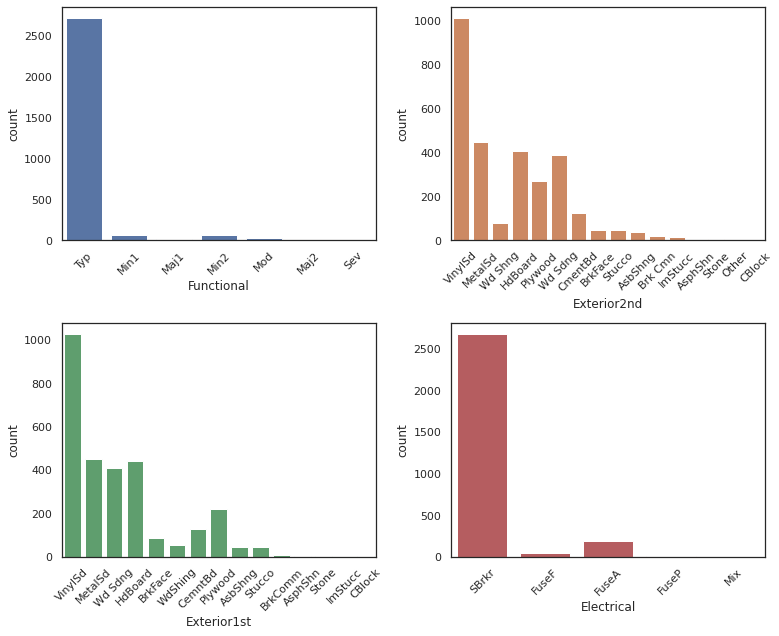

<Figure size 432x288 with 0 Axes>

In [24]:
Function_feat = ["Functional","Exterior2nd","Exterior1st","Electrical"]
multiplot(data = dataset, features = Function_feat, plottype = "countplot", nrows = 2, ncols = 2, figsize = (11,9), colorize = True)
dataset["Functional"] = dataset["Functional"].fillna("Typ")
dataset["Exterior2nd"] = dataset["Exterior2nd"].fillna("VinylSd")
dataset["Exterior1st"] = dataset["Exterior1st"].fillna("VinylSd")
dataset["Electrical"] = dataset["Electrical"].fillna("SBrkr")

Concernant ces variables, je remplace les données manquantes par la valeur catégorielle la plus commune.

# 5 Transformation des données


## 5.1 Variables qualitatives

Je transforme les variables quantitatives `MSSubClass`, `MoSold` and `YrSold` en variables qualitatives.


In [25]:
dataset = dataset.replace({'MSSubClass': {20: 'SubClass_20', 30: 'SubClass_30',40: 'SubClass_40',
45: 'SubClass_45',50: 'SubClass_50',60: 'SubClass_60',70: 'SubClass_70',
75: 'SubClass_75',80: 'SubClass_80',85: 'SubClass_85',90: 'SubClass_90',
120: 'SubClass_120',150: 'SubClass_150',160: 'SubClass_160',180: 'SubClass_180',
190: 'SubClass_190'}})
dataset = dataset.replace({'MoSold': {1: 'Jan', 2: 'Feb',3: 'Mar',
4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sep',10: 'Oct',
11: 'Nov',12: 'Dec'}})
dataset['YrSold'] = dataset['YrSold'].astype(str)

### 5.1.1 variables qualitatives ordinales

In [26]:
## Categorical values
## Ordered
cat_dtype = pd.api.types.CategoricalDtype(categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True)
dataset["BsmtCond"] = dataset["BsmtCond"].astype(cat_dtype).cat.codes
cat_dtype = pd.api.types.CategoricalDtype(categories=['No','Mn','Av','Gd'],ordered=True)
dataset["BsmtExposure"] = dataset["BsmtExposure"].astype(cat_dtype).cat.codes
cat_dtype = pd.api.types.CategoricalDtype(categories=['No','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],ordered=True)
dataset["BsmtFinType1"] = dataset["BsmtFinType1"].astype(cat_dtype).cat.codes
dataset["BsmtFinType2"] = dataset["BsmtFinType2"].astype(cat_dtype).cat.codes
cat_dtype = pd.api.types.CategoricalDtype(categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True)
dataset["BsmtQual"] = dataset["BsmtQual"].astype(cat_dtype).cat.codes
cat_dtype = pd.api.types.CategoricalDtype(categories=['Po','Fa','TA','Gd','Ex'],ordered=True)
dataset["ExterCond"] = dataset["ExterCond"].astype(cat_dtype).cat.codes
dataset["ExterQual"] = dataset["ExterQual"].astype(cat_dtype).cat.codes
cat_dtype = pd.api.types.CategoricalDtype(categories=['No','MnWw','GdWo','MnPrv','GdPrv'],ordered=True)
dataset["Fence"] = dataset["Fence"].astype(cat_dtype).cat.codes
cat_dtype = pd.api.types.CategoricalDtype(categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True)
dataset["FireplaceQu"] = dataset["FireplaceQu"].astype(cat_dtype).cat.codes
cat_dtype = pd.api.types.CategoricalDtype(categories=['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],ordered=True)
dataset["Functional"] = dataset["Functional"].astype(cat_dtype).cat.codes
cat_dtype = pd.api.types.CategoricalDtype(categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True)
dataset["GarageCond"] = dataset["GarageCond"].astype(cat_dtype).cat.codes
dataset["GarageQual"] = dataset["GarageQual"].astype(cat_dtype).cat.codes
cat_dtype = pd.api.types.CategoricalDtype(categories=['No','Unf','RFn','Fin'],ordered=True)
dataset["GarageFinish"] = dataset["GarageFinish"].astype(cat_dtype).cat.codes
cat_dtype = pd.api.types.CategoricalDtype(categories=['Po','Fa','TA','Gd','Ex'],ordered=True)
dataset["HeatingQC"] = dataset["HeatingQC"].astype(cat_dtype).cat.codes
dataset["KitchenQual"] = dataset["KitchenQual"].astype(cat_dtype).cat.codes
cat_dtype = pd.api.types.CategoricalDtype(categories=['N','P','Y'],ordered=True)
dataset["PavedDrive"] = dataset["PavedDrive"].astype(cat_dtype).cat.codes
cat_dtype = pd.api.types.CategoricalDtype(categories=['No','Fa','TA','Gd','Ex'],ordered=True)
dataset["PoolQC"] = dataset["PoolQC"].astype(cat_dtype).cat.codes
cat_dtype = pd.api.types.CategoricalDtype(categories=['ELO','NoSeWa','NoSewr','AllPub'],ordered=True)
dataset["Utilities"] = dataset["Utilities"].astype(cat_dtype).cat.codes

### 5.1.1 variables qualitatives nominales



In [27]:
## non ordered
dataset = pd.get_dummies(dataset, columns=["Alley","BldgType","CentralAir","Condition1","Condition2","Electrical","Exterior1st","Exterior2nd","Foundation","GarageType","Heating","HouseStyle","LandContour","LandSlope","LotConfig","LotShape","MSZoning","MasVnrType","MiscFeature","Neighborhood","RoofMatl","RoofStyle","SaleCondition","SaleType","Street","MSSubClass",'MoSold','YrSold'], drop_first=True)
## ces variables sont colineaires
dataset = dataset.drop(labels=['MSSubClass_SubClass_150','Condition2_PosN', 'MSSubClass_SubClass_160'],axis = 1)



## 5.2 Variables quantitatives

### 5.2.1 Réduire l'assymétrie

Je dois réduire l'assymétrie de la distribution des variables quantitatives car j'ai besoin d'utiliser des distributions normales pour appliquer un modéle de regression linéaire.

Observons d'abord l'assymétrie des variables quantitatives :

<Figure size 432x288 with 0 Axes>

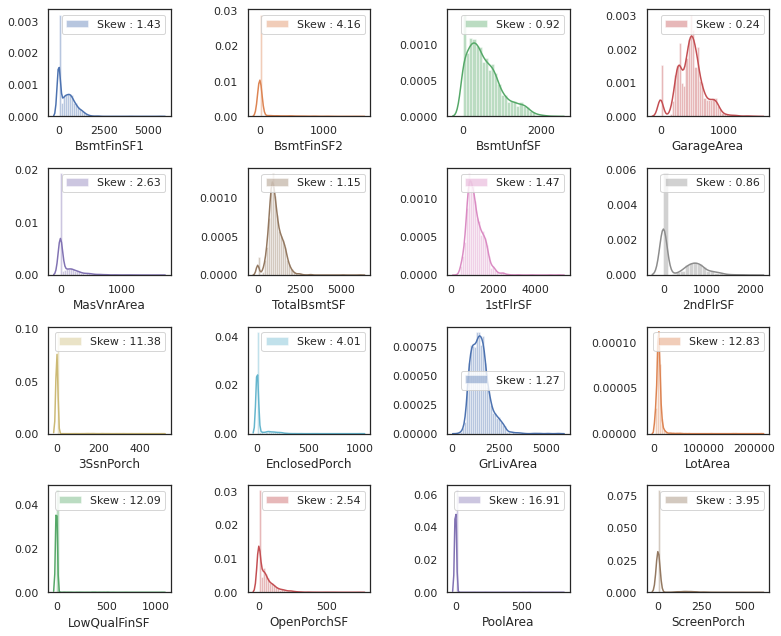

<Figure size 432x288 with 0 Axes>

In [28]:
## print skewed features
skewed_features = ["BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","GarageArea","MasVnrArea", "TotalBsmtSF","1stFlrSF","2ndFlrSF","3SsnPorch","EnclosedPorch", "GrLivArea","LotArea","LowQualFinSF","OpenPorchSF","PoolArea","ScreenPorch","WoodDeckSF"]
multiplot(data = dataset,features = skewed_features,plottype = "distplot", nrows = 4, ncols = 4, figsize = (11,9), colorize = True)

Comme la plupart de ces variables ont une assymétrie de distribution positive, j'applique une transformation logarithme pour corriger l'assymétrie.

In [29]:
for feature in skewed_features:
    dataset[feature] = np.log1p(dataset[feature])

La distribution log-corrigée des variables quantitatives du jeu de donnée :

<Figure size 432x288 with 0 Axes>

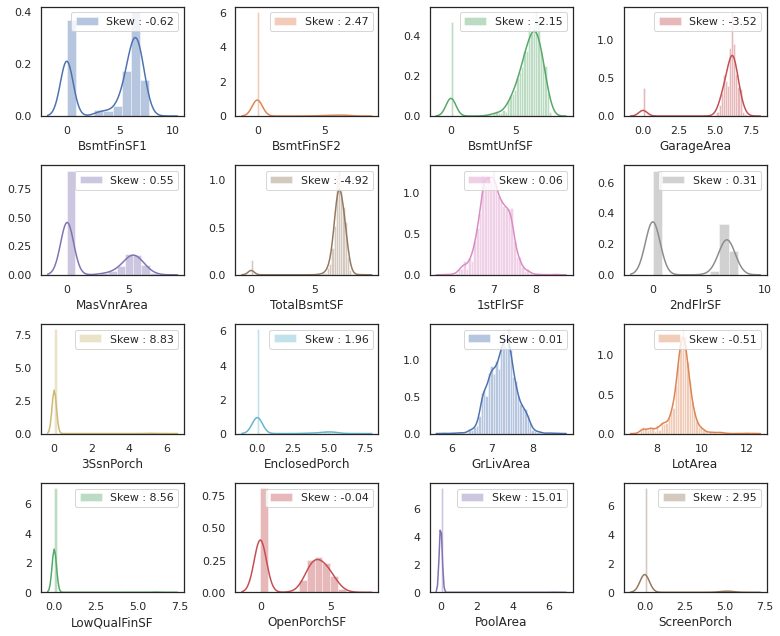

<Figure size 432x288 with 0 Axes>

In [30]:
multiplot(data = dataset,features = skewed_features,plottype = "distplot", nrows = 4, ncols = 4, figsize = (11,9), colorize = True)

Cette transformation logarithmique a corrigé l'assymétrie de la distribution en partie. Toutefois, je me concentre sur la variable `GrLivArea` qui est la plus corrélée à `SalePrice`.

Maintenant je normalise la variable `SalePrice`.

<Figure size 432x288 with 0 Axes>

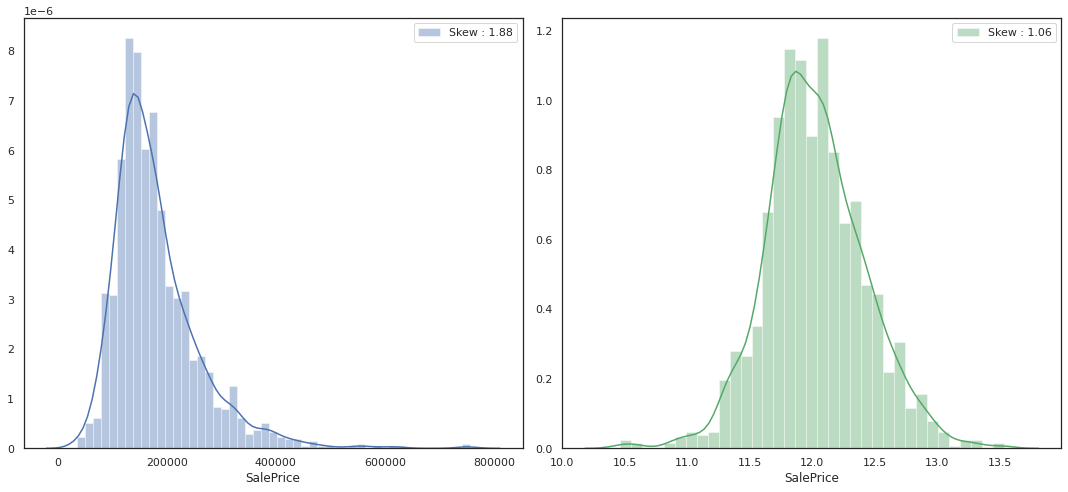

<Figure size 432x288 with 0 Axes>

In [31]:
plt.figure(1)
fig, axes = plt.subplots(1,2,figsize=(15,7))

sns.distplot(train["SalePrice"],ax = axes[0])
sns.distplot(np.log1p(train["SalePrice"]),ax = axes[1],color="g")

axes[0].legend(["Skew : {:.2f}".format(train["SalePrice"].skew())])
axes[1].legend(["Skew : {:.2f}".format(np.log1p(train["SalePrice"].skew()))])

plt.tight_layout()
plt.show()
plt.gcf().clear()

Cette transformation est vraiment necessaire, il s'agit de la variable dépendante et elle suit desormais une distribution normale.

In [32]:
dataset["SalePrice"] = np.log1p(dataset["SalePrice"])
Y = dataset["SalePrice"]
dataset = dataset.drop(labels="SalePrice", axis = 1)

### 5.3 Normalisation

Toutes nos variables ont des échelles de valeurs différentes. Je dois donc les normaliser. La transformation logarithme a cependant déjà mise à l'échelle les variables transformées. 



In [33]:
features = dataset.columns
LotF = dataset["LotFrontage"]
dataset = dataset.drop(labels="LotFrontage", axis= 1)

In [34]:
## Normalize data 
from sklearn.preprocessing import LabelEncoder

N = RobustScaler()
N.fit(dataset)
dataset = N.transform(dataset)

# Modelisation



In [35]:
## Separate train dataset and test dataset
X_train = dataset[:train_len]
test = dataset[train_len:]